# MSP Simulation Example - Resistive Companion -

## Sample Circuit

<img src="Circuit_Exercise_Task1.png" width="400" align="left">

$R_1$ $=0.2 \Omega$ <br>
$L_1$ $=1mH$ <br>
$I_1$$=10A$ <br> 
$i_L(0)=0 $  <br>

## Circuit and Simulation Setup

In [1]:
import numpy as np
import ipywidgets as widget
import matplotlib.pyplot as plt
np.set_printoptions(sign=' ')

# Circuit parameters
R1 = 0.2
L1 = 1e-3
I_src= 10
G1 = 1/R1

## DC equivalent of Inductor

### Equation of the inductor:

$v_L(t) =L\cdot\frac{di_L}{dt}$

### Integration:   

$i_L(t+\Delta{t}) =i_L(t) + \frac{1}{L} \int_{t}^{t+\Delta{t}} \ v_L(\tau) d\tau$

### Discretization:   

$i_L(k+1)= i_L(k) + \frac{1}{L} \int_{t_k}^{t_k+\Delta{t}} \ v_L(\tau) d\tau$

### Application of trapezoidal rule:  

$i_L(k)= i_L(k) + \frac{1}{L} \frac{v_L(k)+v_L(k+1)}{2} \Delta{t} $

$i_L(k+1)=\frac{\Delta{t}}{2L} v_L(k+1) + (i_L(k) + \frac{\Delta{t}}{2L} v_L(k))  $

The inductor in the calculation step (k + 1) can be substituted with an inductance  $G_L = \frac{\Delta{t}}{2L}$ in parallel with a current source $A_L(k) = i_L(k) + \frac{\Delta{t}}{2L} v_L(k) $ 






<img src="Circuit_Exercise_Task1_DCequivalents.png" width="400" align="left">

## Run Simulation

In [ ]:
# Perform simulation with dpsim
import dpsim

# Simulation parameters
model_name = 'CS_R1L1'
time_step = 1e-4
final_time = 1e-3
npoint = int(np.round(final_time/time_step))

# Nodes
gnd = dpsim.emt.Node.GND()
n1 = dpsim.emt.Node('n1')
n1.set_initial_voltage(voltage=complex(2,0),index=0)

# Components
r1 = dpsim.emt.ph1.Resistor('r1')
r1.R = 0.2
l1 = dpsim.emt.ph1.Inductor('l1')
l1.L = 1e-3
cs = dpsim.emt.ph1.CurrentSource('cs')
cs.I_ref = complex(10,0)
cs.f_src = 0

cs.connect([gnd, n1])
r1.connect([n1, gnd])
l1.connect([n1, gnd])


system = dpsim.SystemTopology(50, [gnd, n1], [cs, r1, l1])

logger = dpsim.Logger(model_name)
logger.log_attribute(n1, 'v');
logger.log_attribute(r1, 'i_intf');
logger.log_attribute(l1, 'i_intf');

sim = dpsim.Simulation(model_name, system, timestep=time_step, duration=final_time, pbar=True, sim_type=1, log_level=1)
sim.add_logger(logger)

sim.start()

In [14]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import re

work_dir = 'logs/'
log_path = work_dir + model_name + '_Solver.log'
log_lines, log_sections = read_dpsim_log(log_path)

for line_pos in log_sections['sysmat_stamp']:
    print(log_lines[line_pos])
    
for line_pos in log_sections['sourcevec_stamp']:
    print(log_lines[line_pos])

## Read and show solution log

In [15]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import re

work_dir = 'logs/'
model_name = 'CS_R1L1'
log_path = work_dir + model_name + '.csv'
ts_dpsim_emt = read_timeseries_dpsim(log_path, print_status=False)

for key, val in ts_dpsim_emt.items():
    print(key + ': ' + str(val.values))

l1.i_intf: [-0.09901  -0.295069 -0.487246 -0.675617 -0.860259 -1.041244 -1.218645
 -1.392533 -1.562978 -1.730048]
n1.v: [ 1.980198  1.940986  1.902551  1.864877  1.827948  1.791751  1.756271
  1.721493  1.687404  1.65399 ]
r1.i_intf: [-9.90099  -9.704931 -9.512754 -9.324383 -9.139741 -8.958756 -8.781355
 -8.607467 -8.437022 -8.269952]


## Plot results

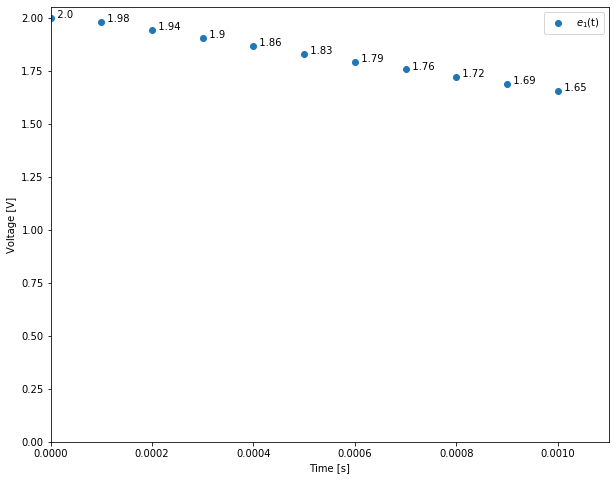

In [16]:
import matplotlib.pyplot as plt

#Extract plot data
plot_data=ts_dpsim_emt["n1.v"]
y_values= np.asarray(plot_data.values)

#Add initial value
y_values= np.insert(y_values, 0, I_src*R1)
t = np.arange(npoint+1)*time_step

plt.figure(figsize=(10,8))
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.axis([0, final_time+time_step , 0, 2.05])
plt.scatter(t,y_values, label='$e_{1}$(t)')

#show corresponding values on the plot
for i in np.arange(npoint+1):
    plt.annotate('  ' + str(np.round(y_values[i], 2)), (t[i], y_values[i]))

plt.legend(loc='upper right')
plt.show()